<a href="https://colab.research.google.com/github/kotekjedi/GANs-ITMO-2022-Masters/blob/main/Assignment%201/1_gan_dcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Models
***

**ITMO University, Autumn 2022, MSc course**


## Assignment 1

***


*Authored by Arip Asadulaev & Manh Lab*

*Adapted by Alexander Panfilov*

***


The assignment is split into two parts: at first, you will implement classical GAN for the MNIST dataset, and after, you will enhance your results with DCGAN and the CIFAR10 dataset. 

Good luck!

## 1. GAN
*Source: <a href="https://arxiv.org/pdf/1406.2661.pdf" target="_blank">Goodfellow, Ian J., et al. "Generative Adversarial Networks." arXiv preprint arXiv:1406.2661 (2014)</a>.*

In 2014, Ian Goodfellow and his colleagues at the University of Montreal published a stunning paper introducing the world to GANs, or generative adversarial networks. The models play two distinct (literally, adversarial) roles. Given some real data set $\mathcal{X}$, $G$ is the generator, trying to create fake data that looks just like the genuine data, while $D$ is the discriminator, getting data from either the real set or $G$ and labeling the difference.

Goodfellow’s metaphor (and a fine one it is) was that $G$ was like a team of forgers trying to match real paintings with their output, while $D$ was the team of detectives trying to tell the difference. (Except in this case, the forgers $G$ never get to see the original data — only the judgments of $D$. They’re like blind forgers.)

<img src="https://production-media.paperswithcode.com/methods/gan.jpeg" style="display=block; margin:auto"/>
<p style="text-align: center">
    <b>Picture taken from the <a href="https://paperswithcode.com/method/gan" target="_blank">paperswithcode</a> website. There you can find a whole bunch of papers on GANs with implementation.</b>
</p>

In this part, we are going to implement classical GAN. You can find a rough plan on how to do it below; however, it is not mandatory to stick with it precisely but one might expect some questions related to the listed steps. Feel free to adapt provided code!

- Define the parameters
- Load the data (with transforms and normalization)
- Denormalize for visual inspection of samples
- Define the Discriminator network, the Generator network
- Study the activation function: Leaky ReLU
- Explain the output activation function: Tanh, Sigmoid
- Look at some sample outputs
- Define losses, optimizers and helper functions for training
     - For Discriminator
     - For Generator
- Train the model
- Save intermediate generated images to file
- Look at some outputs
- Save the models

### Imports

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
from torchvision.datasets import CIFAR10, MNIST
from torchvision.transforms import Compose, Normalize, ToTensor
from torchvision.utils import save_image

%matplotlib inline
plt.style.use("ggplot")

c:\Users\mars\Desktop\aml why did i do it\lab_3_gan\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Define parameters & data loading 

In [3]:
hidden_size = 256
batch_size = 100
LR = 0.0002
num_epochs = 300
sample_dir = "./images"
latent_size = 64  # input random input vector latent
image_size = 784  # 28*28 flatten
device = "cuda" if torch.cuda.is_available() else "cpu"
# 9 cuda нужна :(
print(device)

if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)
## Define the dataset
mnist_dataset = MNIST(
    root="data",
    train=True,
    download=True,
    transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]),
)

cpu


Label:  5


(array([55.,  4.,  3.,  0.,  3.,  2.,  1.,  0.,  1.,  3.,  1.,  3.,  2.,
         1., 21.]),
 array([-1.        , -0.86771244, -0.73542482, -0.60313725, -0.47084966,
        -0.3385621 , -0.20627451, -0.07398693,  0.05830066,  0.19058824,
         0.32287583,  0.45516339,  0.58745098,  0.71973854,  0.85202616,
         0.98431373]),
 <BarContainer object of 15 artists>)

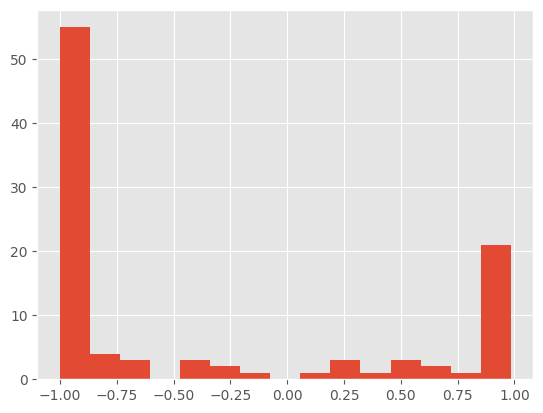

In [4]:
img, label = mnist_dataset[0]
print("Label: ", label)
plt.hist(img[:, 5:15, 5:15].flatten(), bins=15)

In [5]:
# denormalization image from range (-1)-1 to range 0-1 to display it
def denorm(x):
    return (x + 1) / 2

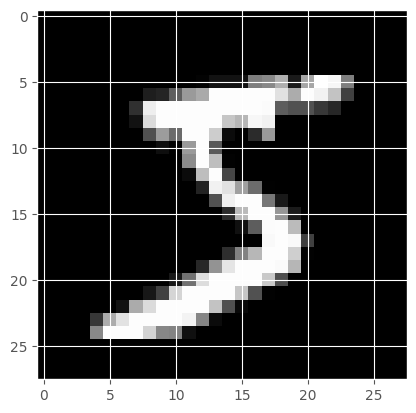

In [6]:
# show image sample with matplotlib
plt.imshow(denorm(img[0]), cmap='gray')

In [7]:
# define the dataloader
from torch.utils.data import DataLoader
data_loader = DataLoader(dataset = mnist_dataset, shuffle = True, batch_size = batch_size)

### GAN implementation

GAN consists of two deep networks, a generator ($G$) and a discriminator ($D$). The generator creates images before learning it. Since the discriminator is a binary classification model, we can use the binary cross-entropy loss function to quantify how well it can distinguish between real and generated images.

In [116]:
class Generator(nn.Module):
    def __init__(self, latent_size, image_size, hidden_size):
        super(Generator, self).__init__()
        ## set a linear layer with input size is image_size and output size is hidden_size
        
        # на картинке latent_size ну и сам смысл генератора ))
        self.linear_1 = nn.Linear(latent_size, hidden_size)
        # set a linear layer with input size is hidden_size and output size is hidden_size
        self.linear_2 = nn.Linear(hidden_size, hidden_size)
        # set a linear layer with input size is hidden_size and output size is image_size
        self.linear_3 = nn.Linear(hidden_size, image_size)

        self.model = nn.Sequential(self.linear_1, nn.ReLU(), self.linear_2, nn.ReLU(), self.linear_3, nn.Tanh())

    def forward(self, x):
        # forward x -> linear1 -> relu -> linear2 -> relu -> linear3 -> tanh
        return self.model(x)

# The ReLU activation is used in the generator with the exception of the output layer which uses the Tanh function. […] Within the discriminator we found the leaky rectified activation to work well …

class Discriminator(nn.Module):
    def __init__(self, image_size, hidden_size):
        super(Discriminator, self).__init__()
        ## set a linear layer with input size is latent_size and output size is hidden_size

        # опять же
        self.linear_1 = nn.Linear(image_size, hidden_size)
        # set a linear layer with input size is hidden_size and output size is hidden_size
        self.linear_2 = nn.Linear(hidden_size, hidden_size)
        # set a linear layer with input size is hidden_size and output size is 1
        self.linear_3 = nn.Linear(hidden_size, 1)

        self.model = nn.Sequential(self.linear_1, nn.LeakyReLU(), self.linear_2, nn.LeakyReLU(), self.linear_3, nn.Sigmoid())

    def forward(self, x):
        # forward x -> linear1 -> relu -> linear2 -> relu -> linear3 -> sigmoid
        return self.model(x)

### Create the Generator and Discriminator

In [117]:
# create new Generator model

# G = Generator...
G = Generator(latent_size, image_size, hidden_size)
G = G.to(device)

# create new Discriminator model

# D = Discriminator...
D = Discriminator(image_size, hidden_size)
D = D.to(device)

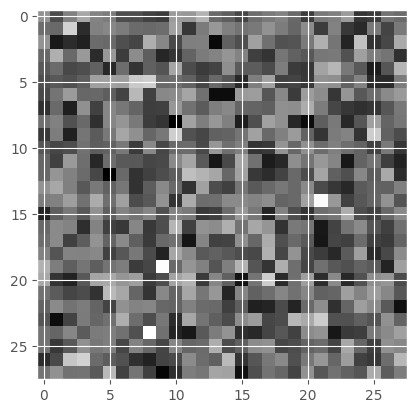

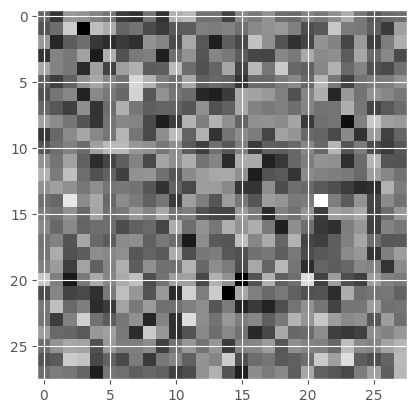

In [118]:
# show the output of model
y = G(torch.randn(2, latent_size))

plt.imshow(y.detach()[0].reshape(28, 28), cmap='gray')
plt.show()
plt.imshow(y.detach()[1].reshape(28, 28), cmap='gray')

In [119]:
# define the criterion is nn.BCELoss()
loss_fn = nn.BCELoss()
## Define the optimizer for generator and discrimator
g_optimizer = torch.optim.Adam(G.parameters(), lr=LR, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(D.parameters(), lr=LR, betas=(0.5, 0.999))
# Tips for Training Stable Generative Adversarial Networks

Discriminator Training

In [11]:
def reset_grad():
    ## reset gradient for optimizer of generator and discrimator
    g_optimizer.zero_grad()
    d_optimizer.zero_grad()

def train_discriminator(D_model, G_model, images, device=device, batch_size=batch_size, latent_size=latent_size, additional_sizes = None):
  
    extra = []
    if additional_sizes is not None:
        extra = additional_sizes

    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1, *extra).to(device)
    fake_labels = torch.zeros(batch_size, 1, *extra).to(device)
        
    
    outputs = D_model(images)
    # Loss for real images
    
    real_score = outputs


    # Loss for fake images
    z = torch.randn(batch_size, latent_size, *extra).to(device)
    fake_images = G_model(z)
    outputs = D_model(fake_images)

    fake_score = outputs

    # Sum losses

    d_loss = loss_fn(real_score, real_labels) + loss_fn(fake_score, fake_labels)

    # Reset gradients
    reset_grad()
    # Compute gradients
    
    # computes gradient of loss w.r.t all the parameters in loss that have requires_grad = True and stores them in parameter.grad attribute for every parameter.
    d_loss.backward()

    # Adjust the parameters using backprop
    
    d_optimizer.step()

    return d_loss, real_score, fake_score

Generator Training

In [9]:
def train_generator(D_model, G_model, device=device, batch_size=batch_size, latent_size=latent_size, additional_sizes = None):
    # Generate fake images and calculate loss
    # z = torch.randn(batch_size, latent_size).to(device)
    extra = []
    if additional_sizes is not None:
        extra = additional_sizes
    z = torch.Tensor(np.random.normal(0, 1, (batch_size, latent_size, *extra))).to(device)
    fake_images = G_model(z)
    labels = torch.ones(batch_size, 1, *extra).to(device)
    # calculate the generator loss

    g_loss = loss_fn(D_model(fake_images), labels)

    # Reset gradients

    reset_grad()

    # Backprop and optimize

    g_loss.backward()
    g_optimizer.step()

    return g_loss, fake_images

### Start the training proccess

In [122]:
# function to save the sample output of generator
def save_fake_images_mnist(G_model, index, sample_dir=sample_dir, device=device, batch_size=batch_size, latent_size=latent_size):
    # sample_vectors = torch.randn(batch_size, latent_size).to(device)
    sample_vectors = torch.Tensor(np.random.normal(0, 1, (batch_size, latent_size))).to(
        device
    )
    fake_images = G_model(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = "fake_images-{0:0=4d}.png".format(index)
    print("Saving", fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

In [126]:
print(device) 
# видюха неактуальная сейчас

cpu


In [125]:
%%time
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
G.to(device)
D.to(device)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator
        d_loss, real_score, fake_score = train_discriminator(D, G, images)
        # Train the generator
        g_loss, fake_images = train_generator(D, G)
        # Inspect the losses
        if (i + 1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print(
                "Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}".format(
                    epoch,
                    num_epochs,
                    i + 1,
                    total_step,
                    d_loss.item(),
                    g_loss.item(),
                    real_score.mean().item(),
                    fake_score.mean().item(),
                )
            )
    # Sample and save images
    save_fake_images_mnist(G, epoch + 1)

Epoch [0/300], Step [200/600], d_loss: 0.5409, g_loss: 2.1005, D(x): 0.73, D(G(z)): 0.08
Epoch [0/300], Step [400/600], d_loss: 0.7743, g_loss: 1.3644, D(x): 0.65, D(G(z)): 0.11
Epoch [0/300], Step [600/600], d_loss: 0.2292, g_loss: 4.1765, D(x): 0.93, D(G(z)): 0.12
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.3915, g_loss: 3.2737, D(x): 0.89, D(G(z)): 0.19
Epoch [1/300], Step [400/600], d_loss: 0.4372, g_loss: 2.5433, D(x): 0.80, D(G(z)): 0.09
Epoch [1/300], Step [600/600], d_loss: 0.2977, g_loss: 3.2032, D(x): 0.86, D(G(z)): 0.10
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.2616, g_loss: 2.0523, D(x): 0.85, D(G(z)): 0.06
Epoch [2/300], Step [400/600], d_loss: 0.2817, g_loss: 3.3207, D(x): 0.85, D(G(z)): 0.04
Epoch [2/300], Step [600/600], d_loss: 0.5302, g_loss: 2.2321, D(x): 0.77, D(G(z)): 0.04
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.4144, g_loss: 2.9925, D(x): 0.82, D(G(z)): 0.05
Epoch [3/300], Step [400/6

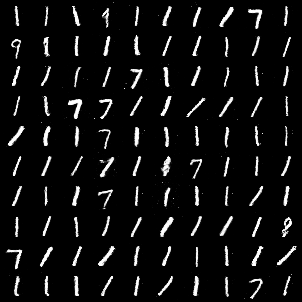

In [128]:
# show output after epochs training
Image.open(os.path.join(sample_dir, "fake_images-0225.png"))

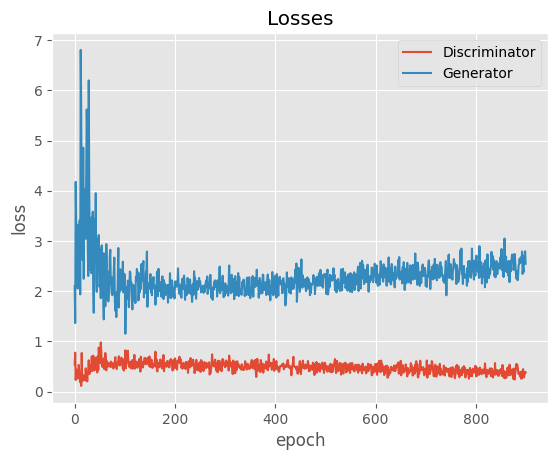

In [129]:
# show the discrimator loss and generator loss
plt.plot(d_losses, "-")
plt.plot(g_losses, "-")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["Discriminator", "Generator"])
plt.title("Losses");

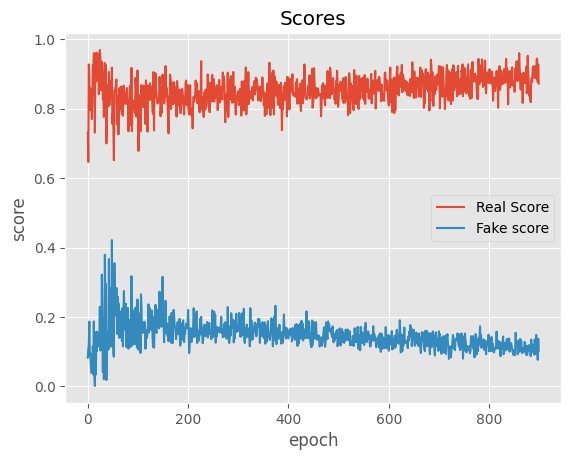

In [130]:
# plot the accuracy of discrimator
plt.plot(real_scores, "-")
plt.plot(fake_scores, "-")
plt.xlabel("epoch")
plt.ylabel("score")
plt.legend(["Real Score", "Fake score"])
plt.title("Scores");

## 2. DCGAN

*Source: <a href="https://arxiv.org/pdf/1511.06434v2.pdf" target="_blank">Radford, Alec, Luke Metz, and Soumith Chintala. "Unsupervised representation learning with deep convolutional generative adversarial networks." arXiv preprint arXiv:1511.06434 (2015)</a>.*

The goal of this part is to enhance your results achieved in the part one with DCGAN. Feel free to reuse your code, improve architecture or training scheme, etc.

In [45]:
class CFG:
    batch_size = 128
    num_epochs = 300
    workers = 4
    seed = 2021
    image_size = 64
    download = True
    dataroot = "data"
    nc = 3  ## number chanels
    ngf = 64  # Size of feature maps in generator
    nz = 100  # latent random input vector
    ndf = 64  # Size of feature maps in discriminator
    lr = 0.0002
    device = "cpu"
    sample_dir = "./images/"


if not os.path.exists(CFG.sample_dir):
    os.makedirs(CFG.sample_dir)

cifar_dataset = CIFAR10(
    root=CFG.dataroot,
    download=CFG.download,
    transform=transforms.Compose(
        [
            transforms.Resize([CFG.image_size, CFG.image_size]),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
)

Files already downloaded and verified


Label:  6


(array([ 3.,  6., 52., 36.,  6.,  4., 12., 40., 40.,  7.,  2.,  6., 22.,
        32., 32.]),
 array([-0.87450981, -0.81124181, -0.74797386, -0.68470585, -0.62143791,
        -0.5581699 , -0.49490196, -0.43163398, -0.36836597, -0.305098  ,
        -0.24183004, -0.17856206, -0.11529408, -0.0520261 ,  0.01124188,
         0.07450986]),
 <BarContainer object of 15 artists>)

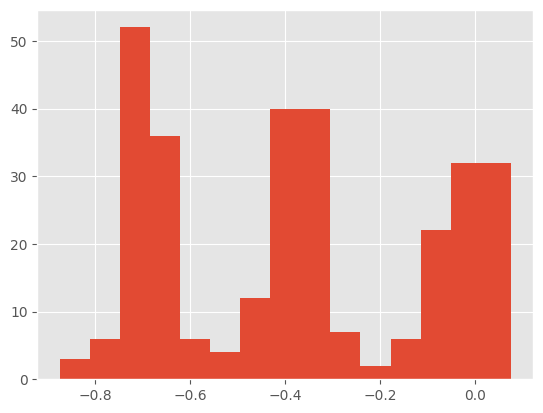

In [46]:
img, label = cifar_dataset[0]
print("Label: ", label)
plt.hist(img[:, 5:15, 5:15].flatten(), bins=15)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


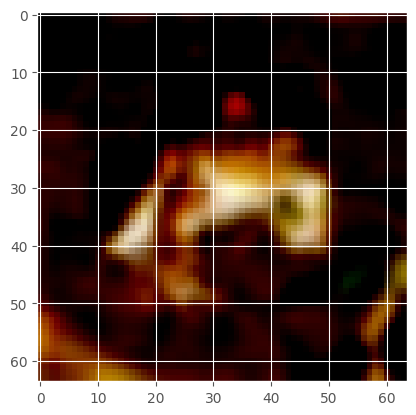

In [47]:
# show image sample with matplotlib

plt.imshow(np.transpose(img, (1, 2, 0)))

In [48]:
# create the dataloader
cifar_data_loader = DataLoader(dataset = cifar_dataset, shuffle = True, batch_size = CFG.batch_size)

### DCGAN implementation

In [49]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

Next is a transposed convolution where typically you’d halve the depth and double the width and height of the previous layer.

In [50]:
class DCGenerator(nn.Module):
    def __init__(self, nc, nz, ngf):
        # ConvTranspose2d - BatchNorm - Relu -ConvTranspose2d - BatchNorm - Relu -ConvTranspose2d - BatchNorm - Relu
        # ConvTranspose2d - BatchNorm - Relu - ConvTranspose2d - Tanh
        super(DCGenerator, self).__init__()
        ##
        self.model = nn.Sequential(
            nn.ConvTranspose2d( nz, ngf * 8, kernel_size=(4, 4), stride=(1, 1), bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 8, ngf * 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d( ngf * 4, ngf * 2, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d( ngf * 2, ngf, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            
            nn.ConvTranspose2d( ngf, nc, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.Tanh()
            
        )

    def forward(self, x):
        ##
        return self.model(x)


class DCDiscriminator(nn.Module):
    def __init__(self, nc, ndf):
        # conv2d - leaky - conv2d - batchnorm - leaky - conv2d - batchnorm - leaky - conv - batchnorm - leaky - conv2d
        super(DCDiscriminator, self).__init__()
        ##
        self.model = nn.Sequential(
            nn.Conv2d(nc, ndf, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf, ndf * 2, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 2, ndf * 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 4, ndf * 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 8, 1, kernel_size=(4, 4), stride=(1, 1), bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        ##
        return self.model(x)

In [51]:
# create new Generator model

# DCG = DCGenerator...
DCG = DCGenerator(CFG.nc, CFG.nz, CFG.ngf)
DCG.apply(weights_init)
DCG.to(device)
# create new Discriminator model

# DCD = DCDiscriminator...
DCD = DCDiscriminator(CFG.nc, CFG.ndf)
DCD.apply(weights_init)
DCG.to(device)

DCGenerator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


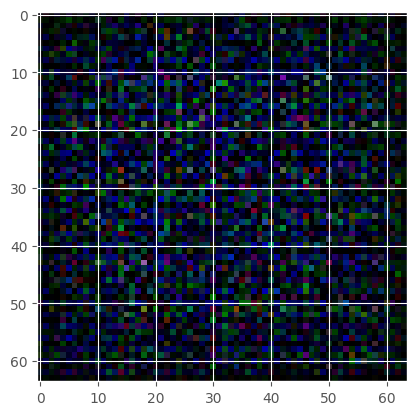

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


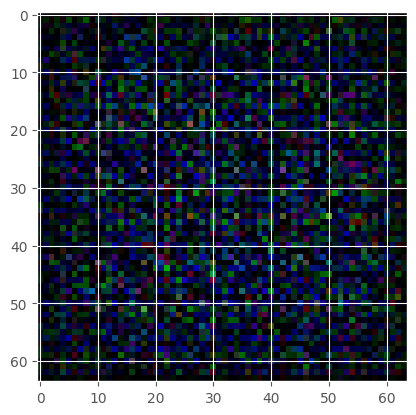

In [52]:
# show the output of model
y = DCG(torch.randn(2, CFG.nz, 1, 1))
plt.imshow(np.transpose(y.detach()[0].reshape(3, 64, 64), (1, 2, 0)))
plt.show()
plt.imshow(np.transpose(y.detach()[1].reshape(3, 64, 64), (1, 2, 0)))

In [53]:
# define the criterion is nn.BCELoss()
loss_fn = nn.BCELoss()
## Define the optimizer for generator and discrimator

g_optimizer = torch.optim.Adam(DCG.parameters(), lr=CFG.lr, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(DCD.parameters(), lr=CFG.lr, betas=(0.5, 0.999))

In [54]:
# feel free to reuse your training functions

### Start the training proccess

In [55]:
def save_fake_images_cifar(DCG_model, index, device=CFG.device, sample_dir=CFG.sample_dir, batch_size=CFG.batch_size):
    sample_vectors = torch.randn(batch_size, CFG.nz, 1, 1).to(device)
    fake_images = DCG_model(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 3, 64, 64)
    fake_fname = "DCG_fake_images-{0:0=4d}.png".format(index)
    print("Saving", fake_fname)
    save_image(
        denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10
    )

In [56]:
from tqdm import tqdm

In [59]:
%%time
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
DCG.to(CFG.device)
DCD.to(CFG.device)
for epoch in range(CFG.num_epochs):
    for i, (images, _) in tqdm(enumerate(cifar_data_loader)):
        if images.size() != torch.Size([128, 3, 64, 64]):
            continue
        # Load a batch & transform to vectors
        images = images.to(CFG.device)

        # Train the discriminator
        d_loss, real_score, fake_score = train_discriminator(DCD, DCG, images, batch_size=CFG.batch_size, latent_size=CFG.nz, additional_sizes=[1,1])
        # Train the generator
        g_loss, fake_images = train_generator(DCD, DCG, batch_size=CFG.batch_size, latent_size=CFG.nz, additional_sizes=[1,1])
        # Inspect the losses
        if (i + 1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print(
                "Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}".format(
                    epoch,
                    CFG.num_epochs,
                    i + 1,
                    total_step,
                    d_loss.item(),
                    g_loss.item(),
                    real_score.mean().item(),
                    fake_score.mean().item(),
                )
            )
    # Sample and save images
    save_fake_images_cifar(DCG, (epoch + 1) * 10 + (i + 1) // 200)
    
    

200it [09:21,  2.78s/it]

Epoch [0/300], Step [200/600], d_loss: 0.3340, g_loss: 4.2863, D(x): 0.82, D(G(z)): 0.08


391it [18:03,  2.77s/it]


Saving DCG_fake_images-0011.png


200it [09:12,  2.83s/it]

Epoch [1/300], Step [200/600], d_loss: 0.4421, g_loss: 2.8911, D(x): 0.79, D(G(z)): 0.14


391it [18:00,  2.76s/it]


Saving DCG_fake_images-0021.png


200it [09:18,  2.80s/it]

Epoch [2/300], Step [200/600], d_loss: 0.9497, g_loss: 7.3531, D(x): 0.97, D(G(z)): 0.54


391it [18:09,  2.79s/it]


Saving DCG_fake_images-0031.png


200it [09:17,  2.76s/it]

Epoch [3/300], Step [200/600], d_loss: 0.4197, g_loss: 4.6823, D(x): 0.88, D(G(z)): 0.22


391it [18:09,  2.79s/it]


Saving DCG_fake_images-0041.png


200it [09:20,  2.76s/it]

Epoch [4/300], Step [200/600], d_loss: 0.3783, g_loss: 3.8343, D(x): 0.90, D(G(z)): 0.22


391it [18:12,  2.79s/it]


Saving DCG_fake_images-0051.png


200it [09:12,  2.89s/it]

Epoch [5/300], Step [200/600], d_loss: 0.5916, g_loss: 2.4011, D(x): 0.73, D(G(z)): 0.18


391it [17:59,  2.76s/it]


Saving DCG_fake_images-0061.png


200it [09:11,  2.72s/it]

Epoch [6/300], Step [200/600], d_loss: 0.4804, g_loss: 2.2764, D(x): 0.82, D(G(z)): 0.20


391it [17:58,  2.76s/it]


Saving DCG_fake_images-0071.png


200it [09:15,  2.68s/it]

Epoch [7/300], Step [200/600], d_loss: 0.7210, g_loss: 1.0266, D(x): 0.59, D(G(z)): 0.09


391it [17:40,  2.71s/it]


Saving DCG_fake_images-0081.png


200it [08:58,  2.72s/it]

Epoch [8/300], Step [200/600], d_loss: 0.2649, g_loss: 3.0015, D(x): 0.86, D(G(z)): 0.10


391it [17:34,  2.70s/it]


Saving DCG_fake_images-0091.png


200it [08:55,  2.66s/it]

Epoch [9/300], Step [200/600], d_loss: 1.1531, g_loss: 1.1974, D(x): 0.41, D(G(z)): 0.11


391it [17:21,  2.66s/it]


Saving DCG_fake_images-0101.png


200it [08:55,  2.63s/it]

Epoch [10/300], Step [200/600], d_loss: 1.0995, g_loss: 3.9642, D(x): 0.97, D(G(z)): 0.59


391it [17:30,  2.69s/it]


Saving DCG_fake_images-0111.png


200it [08:58,  2.71s/it]

Epoch [11/300], Step [200/600], d_loss: 0.1766, g_loss: 4.5504, D(x): 0.96, D(G(z)): 0.12


391it [17:25,  2.67s/it]


Saving DCG_fake_images-0121.png


200it [08:55,  2.64s/it]

Epoch [12/300], Step [200/600], d_loss: 0.6562, g_loss: 2.8520, D(x): 0.80, D(G(z)): 0.32


391it [17:23,  2.67s/it]


Saving DCG_fake_images-0131.png


200it [08:57,  2.67s/it]

Epoch [13/300], Step [200/600], d_loss: 1.6673, g_loss: 0.2892, D(x): 0.30, D(G(z)): 0.20


391it [17:35,  2.70s/it]


Saving DCG_fake_images-0141.png


200it [08:58,  2.62s/it]

Epoch [14/300], Step [200/600], d_loss: 0.6453, g_loss: 4.0801, D(x): 0.81, D(G(z)): 0.31


391it [17:27,  2.68s/it]


Saving DCG_fake_images-0151.png


200it [09:03,  2.74s/it]

Epoch [15/300], Step [200/600], d_loss: 0.6775, g_loss: 1.5917, D(x): 0.64, D(G(z)): 0.16


391it [17:33,  2.69s/it]


Saving DCG_fake_images-0161.png


200it [08:57,  2.65s/it]

Epoch [16/300], Step [200/600], d_loss: 0.6540, g_loss: 3.0332, D(x): 0.58, D(G(z)): 0.03


391it [17:27,  2.68s/it]


Saving DCG_fake_images-0171.png


200it [09:00,  2.70s/it]

Epoch [17/300], Step [200/600], d_loss: 0.7622, g_loss: 1.4536, D(x): 0.58, D(G(z)): 0.14


391it [17:31,  2.69s/it]


Saving DCG_fake_images-0181.png


200it [08:53,  2.75s/it]

Epoch [18/300], Step [200/600], d_loss: 0.8603, g_loss: 1.5124, D(x): 0.66, D(G(z)): 0.30


391it [17:21,  2.66s/it]


Saving DCG_fake_images-0191.png


200it [08:49,  2.69s/it]

Epoch [19/300], Step [200/600], d_loss: 1.0417, g_loss: 1.1323, D(x): 0.49, D(G(z)): 0.20


391it [17:16,  2.65s/it]


Saving DCG_fake_images-0201.png


200it [08:52,  2.65s/it]

Epoch [20/300], Step [200/600], d_loss: 0.4215, g_loss: 3.1292, D(x): 0.85, D(G(z)): 0.20


391it [17:16,  2.65s/it]


Saving DCG_fake_images-0211.png


200it [08:49,  2.65s/it]

Epoch [21/300], Step [200/600], d_loss: 0.7145, g_loss: 2.3411, D(x): 0.79, D(G(z)): 0.32


391it [17:11,  2.64s/it]


Saving DCG_fake_images-0221.png


200it [08:44,  2.59s/it]

Epoch [22/300], Step [200/600], d_loss: 0.4392, g_loss: 3.9130, D(x): 0.89, D(G(z)): 0.24


391it [17:00,  2.61s/it]


Saving DCG_fake_images-0231.png


200it [08:43,  2.63s/it]

Epoch [23/300], Step [200/600], d_loss: 0.9610, g_loss: 4.7200, D(x): 0.97, D(G(z)): 0.55


391it [16:59,  2.61s/it]


Saving DCG_fake_images-0241.png


200it [08:43,  2.59s/it]

Epoch [24/300], Step [200/600], d_loss: 1.0881, g_loss: 1.7038, D(x): 0.48, D(G(z)): 0.17


391it [17:01,  2.61s/it]


Saving DCG_fake_images-0251.png


200it [08:46,  2.57s/it]

Epoch [25/300], Step [200/600], d_loss: 2.7458, g_loss: 0.0074, D(x): 0.09, D(G(z)): 0.01


391it [17:02,  2.62s/it]


Saving DCG_fake_images-0261.png


200it [08:51,  2.58s/it]

Epoch [26/300], Step [200/600], d_loss: 0.3427, g_loss: 4.3860, D(x): 0.94, D(G(z)): 0.23


391it [17:08,  2.63s/it]


Saving DCG_fake_images-0271.png


200it [08:45,  2.66s/it]

Epoch [27/300], Step [200/600], d_loss: 1.0638, g_loss: 8.4787, D(x): 0.93, D(G(z)): 0.58


391it [17:09,  2.63s/it]


Saving DCG_fake_images-0281.png


200it [08:46,  2.67s/it]

Epoch [28/300], Step [200/600], d_loss: 0.4872, g_loss: 1.8149, D(x): 0.77, D(G(z)): 0.17


391it [17:09,  2.63s/it]


Saving DCG_fake_images-0291.png


200it [08:48,  2.62s/it]

Epoch [29/300], Step [200/600], d_loss: 0.4954, g_loss: 2.8140, D(x): 0.72, D(G(z)): 0.12


391it [17:12,  2.64s/it]


Saving DCG_fake_images-0301.png


200it [08:55,  2.64s/it]

Epoch [30/300], Step [200/600], d_loss: 4.1656, g_loss: 0.4677, D(x): 0.02, D(G(z)): 0.01


391it [17:16,  2.65s/it]


Saving DCG_fake_images-0311.png


200it [08:47,  2.62s/it]

Epoch [31/300], Step [200/600], d_loss: 0.8228, g_loss: 2.4334, D(x): 0.69, D(G(z)): 0.32


391it [17:34,  2.70s/it]


Saving DCG_fake_images-0321.png


200it [09:15,  2.66s/it]

Epoch [32/300], Step [200/600], d_loss: 0.3992, g_loss: 2.1793, D(x): 0.81, D(G(z)): 0.15


391it [18:03,  2.77s/it]


Saving DCG_fake_images-0331.png


200it [09:14,  2.72s/it]

Epoch [33/300], Step [200/600], d_loss: 0.0641, g_loss: 4.2420, D(x): 0.96, D(G(z)): 0.03


391it [18:02,  2.77s/it]


Saving DCG_fake_images-0341.png


88it [04:17,  2.92s/it]


KeyboardInterrupt: 

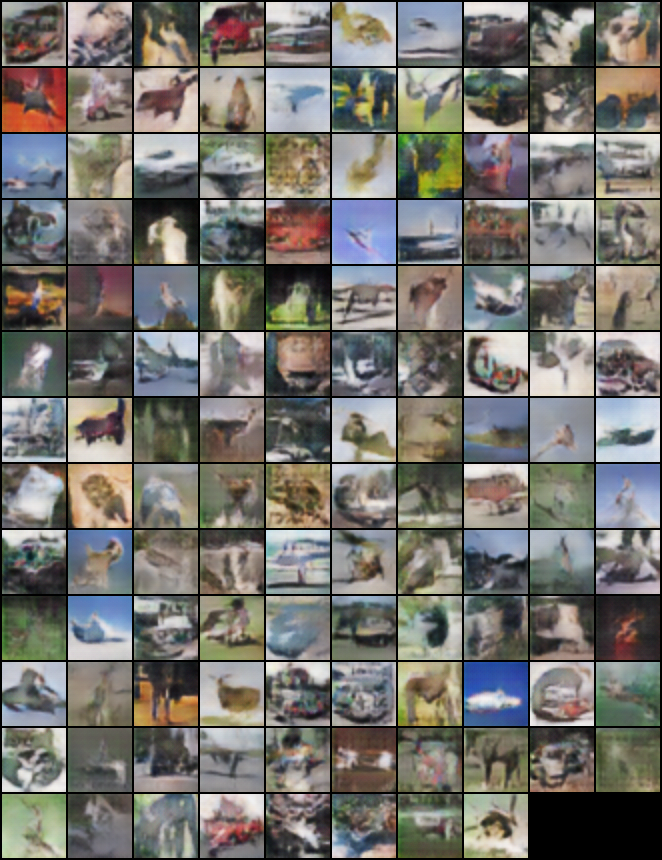

In [60]:
# show your results!
Image.open(os.path.join(sample_dir, "DCG_fake_images-0331.png"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


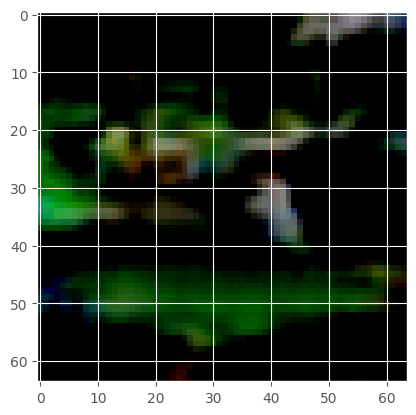

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


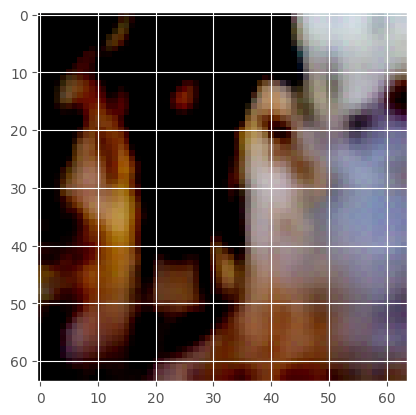

In [61]:
# show the output of model
y = DCG(torch.randn(2, CFG.nz, 1, 1))
plt.imshow(np.transpose(y.detach()[0].reshape(3, 64, 64), (1, 2, 0)))
plt.show()
plt.imshow(np.transpose(y.detach()[1].reshape(3, 64, 64), (1, 2, 0)))

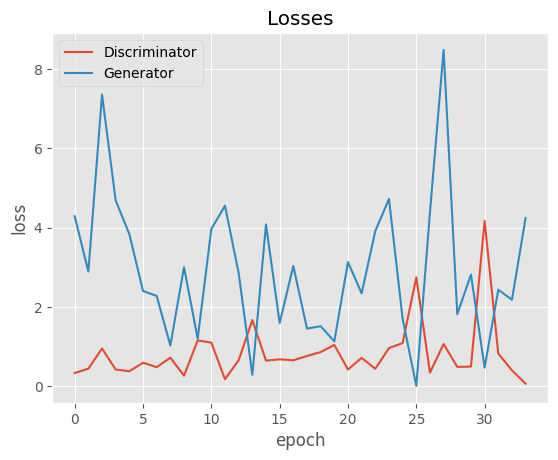

In [62]:
# show the discrimator loss and generator loss
plt.plot(d_losses, "-")
plt.plot(g_losses, "-")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["Discriminator", "Generator"])
plt.title("Losses");

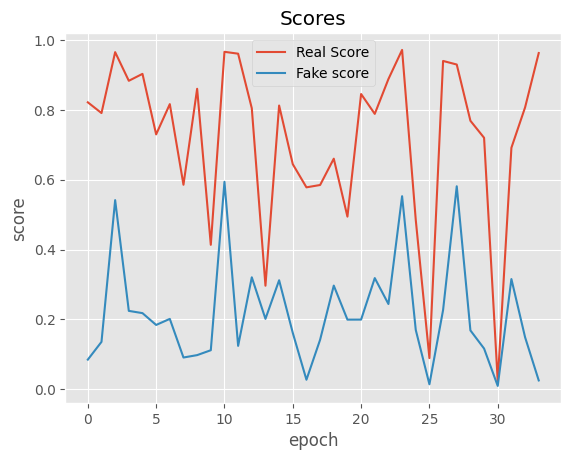

In [63]:
# plot the accuracy of discrimator
plt.plot(real_scores, "-")
plt.plot(fake_scores, "-")
plt.xlabel("epoch")
plt.ylabel("score")
plt.legend(["Real Score", "Fake score"])
plt.title("Scores");